# Import libraries

In [ ]:
import math
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Process, Queue
import numpy as np
import pandas as pd
import sklearn.preprocessing as skp
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
from imblearn.over_sampling import RandomOverSampler, SMOTENC
import threading
import json
from collections import Counter

In [ ]:
import imblearn
print(imblearn.__version__)

0.10.1


# Global variables

In [ ]:
MODEL_CONFIG = 'model/config.json'

DATA_PATH = 'data/raw_data.csv'

# ------------- Train, Test, Validation Set ----------- #
TEST_DF_PATH = 'data/test_df.csv'
TRAIN_DF_PATH = 'data/train_df.csv'
VALID_DF_PATH = 'data/valid_df.csv'

H_POP_PATH = 'data/h_population.csv'

# ------------------- Model Training ----------------- #
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random_state = 2023
torch.manual_seed(random_state)
np.random.seed(random_state)
debug = False
MODEL_PATH = 'model/tfm.pt'

In [ ]:
MAX_ITERS = 1000 # @param {type:"slider", min:100, max:2000, step:100}


In [ ]:
# Load model config
with open(MODEL_CONFIG, 'r') as openfile:
    prm_json = json.load(openfile)

batch_size = prm_json["batch_size"]
block_size = prm_json["block_size"]
eval_interval = prm_json["eval_interval"]
learning_rate = prm_json["learning_rate"]
eval_iters = prm_json["eval_iters"]
n_embd = prm_json["n_embd"]
n_head = prm_json["n_head"]
n_layer = prm_json["n_layer"]
dropout = prm_json["dropout"]
vocab_size = prm_json["vocab_size"]
max_vocab = prm_json["max_vocab"]


print(f"""batch_size: {batch_size}, block_size: {block_size},
eval_interval: {eval_interval}, learning_rate: {learning_rate},
eval_iters: {eval_iters}, n_embd: {n_embd},
n_head: {n_head}, n_layer: {n_layer}, dropout: {dropout},
vocab_size: {vocab_size}, max_vocab: {max_vocab}""")

batch_size: 32, block_size: 4,
eval_interval: 10, learning_rate: 0.0001,
eval_iters: 10, n_embd: 512,
n_head: 8, n_layer: 6, dropout: 0.1,
vocab_size: 112, max_vocab: 409


# Util Functions

In [ ]:
def binning(df, column, bin_edges, labels=None):
    """
    Function that performs binning for a numeric column in a Pandas dataframe.
    df: Pandas dataframe
    column: name of the numeric column to be binned
    bin_edges: list of bin edges to use
    labels: list of labels to assign to the bins
    """
    # Use the Pandas cut function to bin the column
    df[column + '_binned'] = pd.cut(df[column], bins=bin_edges, labels=labels)

    return df

In [ ]:
def compare_attributes(df1, df2, columns_to_plot=None, legend_labels=None):
    if columns_to_plot is None:
        columns_to_plot = df1.columns

    # Iterate over each column in the dataframes
    for i, col in enumerate(columns_to_plot):
        # Create a new figure and axis object for each attribute
        fig, ax = plt.subplots()

        # Get the frequencies for each unique value in the column
        freq1 = df1[col].value_counts()
        freq2 = df2[col].value_counts()

        # Combine the frequencies into a single dataframe
        freq_df = pd.concat([freq1, freq2], axis=1, keys=['df1', 'df2'])

        # Plot the frequencies as a bar chart
        freq_df.plot(kind='bar', ax=ax, rot=0)

        # Set the title for the subplot
        ax.set_title(col)

        # Add a legend to the plot
        plt.legend(legend_labels)

        # Show the plot
        plt.show()


In [ ]:
def count_unique_elements(my_list):
    # Create an empty list to store unique elements
    unique_list = []

    # Loop through each element in the list
    for element in my_list:
        # Check if the element is not already in the unique list
        if element not in unique_list:
            # If it's not, add it to the unique list
            unique_list.append(element)
            unique_list.sort()
            max_vocab = max(unique_list)

    # Return the length of the unique list and the unique list itself
    return len(unique_list), unique_list, max_vocab

In [ ]:
# Convert the model output into a pandas dataframe
def create_dataframe(data_list, num_columns, header=None):
    # Calculate the number of rows needed based on the length of the data_list
    # and the specified number of columns
    num_rows = len(data_list) // num_columns + (len(data_list) % num_columns > 0)

    # Create a 2D array with the data_list values
    data_array = [data_list[i:i+num_columns] for i in range(0, len(data_list), num_columns)]

    # Add empty values to the end of each row to ensure all rows have the same length
    for i in range(len(data_array)):
        while len(data_array[i]) < num_columns:
            data_array[i].append(None)

    # Create a Pandas dataframe from the 2D array
    df = pd.DataFrame(data_array, columns=header)

    return df


In [ ]:
def flatten_list(nested_list):
    flat_list = []
    for inner_list in nested_list:
        for element in inner_list:
            flat_list.append(element)

    return flat_list

In [ ]:
def plot_attribute_distribution(df):
    # check the distribution of each attribute
    # iterate over columns in dataframe
    for col in df.columns:
        # count the frequency of each attribute
        value_counts = df[col].value_counts()
        # create a bar chart of the frequency of each attribute
        plt.figure()
        plt.bar(value_counts.index, value_counts.values)
        plt.title(col)
        plt.show()

In [ ]:
def print_uniq_val(df):
    # Create an empty dictionary to store unique values for each column
    unique_values_dict = {}

    # Iterate through each column of the dataframe
    for column_name in df.columns:
        # Get the unique values of the current column
        unique_values = df[column_name].unique().tolist()

        # Sort the unique values
        unique_values.sort()

        # Store the sorted unique values in the dictionary
        unique_values_dict[column_name] = unique_values

    # Print the unique values for each column
    for column_name, unique_values in unique_values_dict.items():
        print(f"Column name: {column_name}")
        print(f"Unique values: {unique_values}")
        print(f"Total unique values: {len(unique_values)}")
        print("\n")

In [ ]:
def random_sample(df, n, random_state, replace=False):
    """
    Returns a tuple of two dataframes:
    the first dataframe contains n randomly sampled rows from the input dataframe without replacement,
    the second dataframe contains the remaining rows that were not sampled.
    """
    sample_df = df.sample(n=n, replace=replace, random_state=random_state)
    remaining_df = df.drop(sample_df.index)

    return sample_df, remaining_df


In [ ]:
## Standardization
# transform numerical features (normalization)
def transform_continuous(dataset, continuous_cols):
    """
    dataset: Raw dataset not yet normalized

    continuous_cols: a list of continuous columns
    """

    # scaler = MinMaxScaler(feature_range = (0, 1))

    scaler = skp.StandardScaler()

    columns_to_scale = continuous_cols
    scaled_array = scaler.fit_transform(dataset.loc[:, columns_to_scale])
    df_scaled = pd.DataFrame(scaled_array, columns=scaler.get_feature_names_out())
    return df_scaled


# inverse transform normalized vectors
def inverse_transform_continuous(original_dataset, synthetic_dataset, col_list):
    # scaler = skp.MinMaxScaler(feature_range = (0, 1))
    scaler = skp.StandardScaler()
    columns_to_normalize = col_list
    scaler.fit(original_dataset[columns_to_normalize])
    fake_attribute = scaler.inverse_transform(synthetic_dataset[scaler.get_feature_names_out()])
    df = pd.DataFrame(fake_attribute, columns = columns_to_normalize)

    return df

# Load train, test, validation sets

In [ ]:
test_df = pd.read_csv(TEST_DF_PATH)
train_df = pd.read_csv(TRAIN_DF_PATH)
valid_df = pd.read_csv(VALID_DF_PATH)

In [ ]:
print(f"test: {len(test_df)}, train: {len(train_df)}, valid: {len(valid_df)}")

test: 60451, train: 435254, valid: 108814


## Make tensor of valid set

In [ ]:
train_list = train_df.values.flatten().tolist()
valid_list = valid_df.values.flatten().tolist()

print("Example of the train list:")
print(train_list[:block_size])
print("#--------------------#")
print("Example of the valid list:")
print(valid_list[:block_size])
print("#--------------------#")

train_data = torch.tensor(train_list, dtype=torch.long)
val_data = torch.tensor(valid_list, dtype=torch.long)

Example of the train list:
[201, 56, 302, 401]
#--------------------#
Example of the valid list:
[201, 71, 302, 401]
#--------------------#


# Network Components

## Head

In [ ]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

## Multi-head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

## Feed forward

In [ ]:
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

## Block

In [ ]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

## Bigram Model

In [ ]:
# very simple bigram model
class BigramModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token
        # from a lookup table
        self.token_embedding_table = nn.Embedding(max_vocab+1, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, max_vocab+1)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)

        if debug == True:
            print(f"tok_emb: {tok_emb}")

        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            if debug == True:
                print(f"logits: {logits}")
                print(f"targets: {targets}")
                print(f"logits shape: {logits.shape}")
                print(f"targets shape: {targets.shape}")
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
## Train and Test Splits
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))

    if debug == True:
        print(f"ix: {ix}")

    x = torch.stack([data[i:i+block_size] for i in ix])

    if debug == True:
        print(f"x: {x}")

    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    if debug == True:
        print(f"y: {y}")

    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):

            if debug == True:
                print(f"k: {k}")

            X, Y = get_batch(split)

            if debug == True:
                print(f"X: {X}")
                print(f"Y: {Y}")

            logits, loss = model(X, Y)

            if debug == True:
                print(f"logits: {logits}")
                print(f"loss: {loss}")

            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Training Phase

## Train model

In [ ]:
model = BigramModel()
# model.load_state_dict(torch.load(MODEL_PATH))
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

19.32841 M parameters


In [ ]:
train_loss = []
val_loss = []

# get the start time
st = time.time()

for iter in range(MAX_ITERS):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        train_loss.append(losses['train'].numpy())
        val_loss.append(losses['val'].numpy())

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print(f"Training time: {elapsed_time:.2f} seconds")

step 0: train loss 6.0516, val loss 6.0618
step 10: train loss 3.0193, val loss 3.0665
step 20: train loss 2.4836, val loss 2.4571
step 30: train loss 2.1137, val loss 2.1616
step 40: train loss 1.9883, val loss 1.9557
step 50: train loss 1.8643, val loss 1.9340
step 60: train loss 1.8480, val loss 1.8279
step 70: train loss 1.8637, val loss 1.8596
step 80: train loss 1.8270, val loss 1.8804
step 90: train loss 1.7987, val loss 1.7907
step 100: train loss 1.7931, val loss 1.7558
step 110: train loss 1.8440, val loss 1.8304
step 120: train loss 1.7393, val loss 1.7535
step 130: train loss 1.7021, val loss 1.7701
step 140: train loss 1.7490, val loss 1.7457
step 150: train loss 1.7337, val loss 1.7356
step 160: train loss 1.7245, val loss 1.7238
step 170: train loss 1.6913, val loss 1.7319
step 180: train loss 1.7232, val loss 1.6751
step 190: train loss 1.7248, val loss 1.6897
step 200: train loss 1.6853, val loss 1.6725
step 210: train loss 1.6884, val loss 1.7590
step 220: train loss 

In [ ]:
def plot_loss(train_loss, val_loss):
  plt.plot(train_loss, label='train_loss')
  plt.plot(val_loss, label='val_loss')
#   plt.ylim([0, 10])
#   plt.xlim([0,100])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.grid(True)

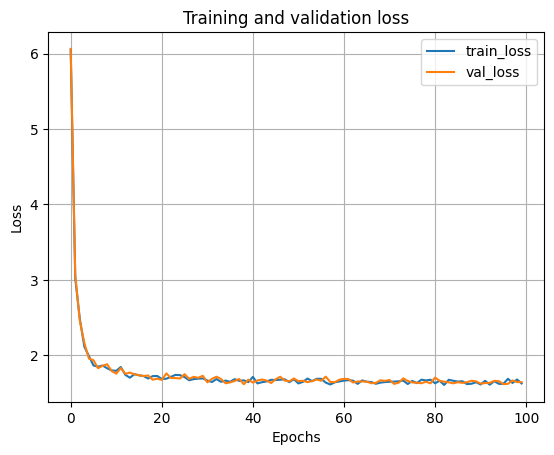

In [ ]:
plot_loss(train_loss, val_loss)

## Save model

In [ ]:
# Save model
torch.save(m.state_dict(), MODEL_PATH)